# Open Ocean
# Open Earth Fundation
---------------------------------------------------------------------------------------------------------------------
Authors: Margaux Filippi & Maureen Fonseca

---------------------------------------------------------------------------------------------------------------------

<h1> Calculating and comparing marine biodiversity metrics for ACMC </h1>

This series of notebooks aims to calculate different marine biodiversity indices, such as:
- WEGE
- STAR
- other Marine Biodiversity Units

for a few areas around Cocos Island, Costa Rica:
- AMMB, or Área Marina de Manejo del Bicentenario (marine protected area that got extended for the bicentennial)
- PNIC, or Parque National de Isla del Coco (Cocos Island national park)
- ACMC, or Area de Conservación Marina Coco (AMMB + PNIC)

We will later extend to the Eastern Tropical Pacific. The data source that we use is UICN.

<h1> Step 2: calculate different metrics </h1>

This notebook shows the second step, the data analysis.

<h2> Data needed for this project </h2>

The data was output by `ACMC_IUCN_step1_curatedata.ipynb` and can be found under [IUCN_RedList](https://drive.google.com/drive/folders/1nkw8VK9mPdthjyDOSsnljqCo_b7lMdP4?usp=sharing) under a temporary folder that accompagnies the GitHub repository: 

`Ocean Program > data > to download for gh > ACMC_IUCN_data`

### Analyzing UICN data for marine species in the Eastern Tropical Pacific.

In [1]:
import geopandas as gpd

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
import glob

In [4]:
from shapely.geometry import Polygon, Point

In [5]:
import fiona; #help(fiona.open)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import timeit

---------------------------------------------------------------------------------------------------------------------
OEF functions

---------------------------------------------------------------------------------------------------------------------

In [8]:
from marinebiodiversity_utils import *

<h1> 1. Load data </h1>

<h2> 1.1 Get the conservation area</h2>

Mostly for plotting.

<h3> Coordinates for Cocos Island </h3>

Cocos Island is located at 05°31′41″N; 87°03′40″W

In [9]:
Cocos_lat = 5+31/60+41/3600
Cocos_lon = -(87+3/60+40/3600)
Cocos = Point(Cocos_lon, Cocos_lat)

<h3> Import entire AMMB and PNIC </h3>

In [10]:
ACMC = gpd.read_file('../../ACMC/ACMC.shp')
AMMB = gpd.read_file('../../ACMC/AMMB.shp')
PNIC = gpd.read_file('../../ACMC/PNIC.shp')

---------------------------------------------------------------------------------------------------------------------
Inspect the Coordinate Reference Systems (CRS).

---------------------------------------------------------------------------------------------------------------------

In [12]:
AMMB.crs

<Derived Projected CRS: EPSG:5367>
Name: CR05 / CRTM05
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Costa Rica - onshore and offshore east of 86°30'W.
- bounds: (-86.5, 2.21, -81.43, 11.77)
Coordinate Operation:
- name: Costa Rica TM 2005
- method: Transverse Mercator
Datum: Costa Rica 2005
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
PNIC.crs

<Derived Projected CRS: EPSG:5367>
Name: CR05 / CRTM05
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Costa Rica - onshore and offshore east of 86°30'W.
- bounds: (-86.5, 2.21, -81.43, 11.77)
Coordinate Operation:
- name: Costa Rica TM 2005
- method: Transverse Mercator
Datum: Costa Rica 2005
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
AMMB_WGS84 = AMMB.to_crs(crs=4326)
PNIC_WGS84 = PNIC.to_crs(crs=4326)
ACMC = ACMC.set_crs(epsg=4326, allow_override=True)

---------------------------------------------------------------------------------------------------------------------
Get area information.

---------------------------------------------------------------------------------------------------------------------

In [15]:
print("Area, PNIC:")
print("{:0.2f}".format(PNIC_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(PNIC_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

print("\nArea, AMMB:")
print("{:0.2f}".format(AMMB_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(AMMB_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

print("\nTotal Area, ACMC:")
print("{:0.2f}".format(AMMB_WGS84.area.item() + PNIC_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(AMMB_WGS84.to_crs(crs=31970).area.item()*10**(-6) + PNIC_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

Area, PNIC:
4.47 sqdeg.
54,799.50 sqkm in CRS 31970.

Area, AMMB:
8.66 sqdeg.
106,243.90 sqkm in CRS 31970.

Total Area, ACMC:
13.13 sqdeg.
161,043.41 sqkm in CRS 31970.


/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_18229/2915868912.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(PNIC_WGS84.area.item()) + " sqdeg.")
/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_18229/2915868912.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(AMMB_WGS84.area.item()) + " sqdeg.")
/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_18229/2915868912.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(AMMB_WGS84.area.item() + PNIC_WGS84.area.item()) + " sqdeg.")

<h2> 1.2 Get the species data </h2>

This is the outcome from `AMMB_IUCN_step1_curatedata.ipynb`.

In [15]:
df = gpd.read_file('../../ACMC_IUCN_data/gdf_ACMC_IUCN_range_status_filtered.shp') 

In [16]:
df.head()

,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,redlistCat,scientific,geometry
0,3,1506081,177969.0,Acanthurus nigricans,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Acanthurus nigricans,"MULTIPOLYGON (((109.79501 6.13966, 109.89836 6..."
1,10,1512439,177988.0,Naso annulatus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Naso annulatus,"MULTIPOLYGON (((109.79501 6.13966, 109.89836 6..."
2,13,1517273,178002.0,Naso hexacanthus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Naso hexacanthus,"MULTIPOLYGON (((99.07516 7.94581, 99.07794 7.9..."
3,97,2412930,195754.0,Gymnothorax meleagris,1,1,1,IUCN Marine Biodiversity Unit/GMSA,2018,IUCN Marine Biodiversity Unit/GMSA,Extant (resident),None,None,None,None,None,Least Concern,Gymnothorax meleagris,"MULTIPOLYGON (((144.23853 -3.82053, 144.24330 ..."
4,102,2423479,195824.0,Uropterygius macrocephalus,1,1,1,IUCN Marine Biodiversity Unit/GMSA,2018,IUCN Marine Biodiversity Unit/GMSA,Extant (resident),None,None,None,None,None,Least Concern,Uropterygius macrocephalus,"MULTIPOLYGON (((144.23853 -3.82053, 144.24330 ..."


With the first version data from Margaux, the data set had 164 unique species, now:

In [17]:
print("There are " + str(len(df)) + " unique species in this dataset.")

There are 640 unique species in this dataset.


In [18]:
print("The columns are:")
print(df.columns)

The columns are:
Index(['index', 'ASSESSMENT', 'ID_NO', 'BINOMIAL', 'PRESENCE', 'ORIGIN',
       'SEASONAL', 'COMPILER', 'YEAR', 'CITATION', 'LEGEND', 'SUBSPECIES',
       'SUBPOP', 'DIST_COMM', 'ISLAND', 'TAX_COMM', 'redlistCat', 'scientific',
       'geometry'],
      dtype='object')


Super annoying ESRI note: the column headers are cropped to 10 characters.

`redlistCat` = `redlistCategory`

`scientific` = `scientificName`

In [19]:
print("There are the following conservation statuses:")
print(df.redlistCat.unique())

There are the following conservation statuses:
['Least Concern' 'Vulnerable' 'Data Deficient' 'Near Threatened'
 'Endangered' 'Critically Endangered']


In [20]:
for status in df.redlistCat.unique():
    print("There are " + str(len(df[df.redlistCat==status])) + \
          " species with the status " + status)

There are 531 species with the status Least Concern
There are 46 species with the status Vulnerable
There are 34 species with the status Data Deficient
There are 10 species with the status Near Threatened
There are 16 species with the status Endangered
There are 3 species with the status Critically Endangered


In [21]:
print("The species with the status Critically Endangered are :")
print(df[df.redlistCat=='Critically Endangered'].BINOMIAL)

The species with the status Critically Endangered are :
566    Carcharhinus longimanus
573     Eretmochelys imbricata
631            Pristis pristis
Name: BINOMIAL, dtype: object


- *Carcharhinus longimanus* is Oceanic whitetip shark
- *Eretmochelys imbricata* is Hawksbill sea turtle
- *Pristis pristis* is Largetooth sawfish

<h1> 2. Preliminary calculations </h1> 

In [25]:
area_of_conservation = ACMC.geometry.item()

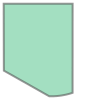

In [26]:
area_of_conservation

<h2> Modulating Factor : Distribution area </h2>

First: DistRatio = $\frac{\text{total conservation area}}{\text{distribution area}}$

In [34]:
df["DistRatio"] = area_of_conservation.area/df.area
df["DistFactorPerc"] = 100*(1+df.DistRatio)
df.head().DistRatio

0    0.009522
1    0.009188
2    0.008233
3    0.009871
4    0.012679
Name: DistRatio, dtype: float64

In [35]:
df.loc[[110, 153, 157, 86, 87]].DistRatio

110    2.562393
153    0.142533
157    2.562393
86     0.173024
87     0.050969
Name: DistRatio, dtype: float64

Note:
`df.loc[[110, 153, 157, 86, 87]].DistRatio`
shows
```
110    0.000358
153    0.000409
157    0.000998
86     0.001967
87     0.000718
Name: DistRatio, dtype: float64
```
and
`AMMB_IUCN_df1.head().DistRatio`
showed
```
110    0.000358
153    0.000409
157    0.000998
86     0.001967
87     0.000718
Name: DistRatio, dtype: float64
```

Second: DistRatio = $\frac{\text{distribution area within total conservation area}}{\text{total distribution area}}$

In [ ]:
# Make new columns
df["DistRatio2"] = 0
df["DistFactorPerc2"] = 0
DistRatio2 = []
DistFactorPerc2 = []

for iter, row in df.iterrows():
    
    df_intersect = df[df.BINOMIAL==row.BINOMIAL].intersection(area_of_conservation)
    ratio2 = (df_intersect.area/df[df.BINOMIAL==row.BINOMIAL].area).sum()

    DistRatio2.append(ratio2)
    DistFactorPerc2.append(100*ratio2)

In [ ]:
df["DistRatio2"] = DistRatio2
df["DistFactorPerc2"] = DistFactorPerc2

In [ ]:
# Now remove all geometries that are outside the AMMB -> clip does the job
df2 = gpd.clip(df.set_crs(epsg=4326, allow_override=True), ACMC)

In [ ]:
df2["DistRatio2"] = df2.area/df.area
df2["DistFactorPerc2"] = 100 * df2.DistRatio2

Verify:

1) Maximum ratios

In [ ]:
print("The species with the highest ratio of conservation area:")
df2[df2.DistRatio2==np.max(df2.DistRatio2)]

In [ ]:
df2[df2['BINOMIAL'] == 'Halichoeres salmofasciatus']

In [ ]:
#margaux result
print("The species with the highest ratio of conservation area:")
df2[df2.DistRatio2==np.max(df2.DistRatio2)]

In [ ]:
print("The species with the highest ratio of conservation area:")
df[df.DistRatio2==np.max(df.DistRatio2)]

In [ ]:
print("Species distratio2, v1:")
print(df[df.ID_NO==183433.0].DistRatio2)
print("Species distratio2, v2:")
print(df2[df2.ID_NO==183433.0].DistRatio2)

2) Minimum ratios

In [ ]:
print("The species with the lowest ratio of conservation area:distribution area is:")
df[df.DistRatio2==np.min(df.DistRatio2)]

In [ ]:
print("The species with the lowest ratio of conservation area:distribution area is:")
df2[df2.DistRatio2==np.min(df2.DistRatio2)]

In [ ]:
print("Species distratio2, v1:")
print(df[df.ID_NO=='60324'].DistRatio2)
print("Species distratio2, v2:")
print(df2[df2.ID_NO=='60324'].DistRatio2)

In [ ]:
print("Species distratio2, v1:")
print(df[df.ID_NO==39375.0].DistRatio2)
print("Species distratio2, v2:")
print(df2[df2.ID_NO==39375.0].DistRatio2)

*Mobula tarapacana* is the Chilean devil ray, which is **Endangered**.

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.max(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 0.25)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)


# ax.set_xlim((-110, -60))
ax.set_ylim((-50, 60))
plt.show();

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(10,5))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.min(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 1)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)


ax.set_xlim((-90, -80))
ax.set_ylim((0, 10))
plt.show();

<h1> 3. Marine Biodiversity Unit </h1>

i.e. we create a base unit and we modulate it with different adjustments: vulnerability, distribution range, etc.

<h2> Base Unit</h2>

This is where we get a biodiversity index for the area. Example:

- get the Shannon index over AMMB
- get another biodiversity score that we normalize against a global score

<h3> Example: Shannon Biodiversity </h3>

The maximum Shannon biodiversity index worldwide is ~8.5.

E.g. around Cocos Island, based on OBIS data (...), a Shannon biodiversity index of 6.25 over 160,000 km$^2$ would give

base credit $ = \frac{6.25 \text{ (local index)}}{8.5 \text{ (max global index)}}) = $ 0.735

total credits = $\frac{6.25 \text{ (local index)}}{8.5 \text{ (max global index)}})\times 160,000 \text{ km}^2 \times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ 117,647 Marine Biodiversity Units

That gives the baseline. To be completed. 

Note: we CANNOT get the Shannon index just from IUCN data. We need the number of specimens for each species.

<h3> Example: species richness </h3>
    
That is: use the total number of species within the area of interest to get the base credit.

Info from SINAC, link to [Google Drive](https://drive.google.com/file/d/1Bztf55bKgZi7X9nJPbWGdOUtW7Zv0-3_/view?usp=sharing) document
```
The CINP is home to 1688 species of marine fauna, of which
45 are endemic. This represents 47,4 % of the endemism in
Costa Rica. In other words, the CINP contributes half of the
country’s unique biological richness.
```
SINAC (Sistema Nacional de Áreas de Conservación). 2018. Importancia de los ecosistemas y las poblaciones del sitio de interés: Parque Nacional Isla del Coco (PNIC), Área Marina de Manejo Montes Submarinos (AMM MS) y aguas adyacentes. Área de Conservación Marina Cocos. San José, Costa Rica. 68 p.

Note: this was the old park
```
The CINP, created in 1978, is located 342 miles (500 km) southeast of Costa Rica’s Pacific coast and covers an area of 785 sq miles (2034 km2). The island comprises an area of about 9 sq miles (23 km2) and the marine area covers the remaining 776 sq miles (2011 km2). The SMMA was created in 2011 and was the first protected wildlife area in this category in Costa Rica. It encompasses 3725 sq miles (9649 km2) of the Pacific Ocean waters around the CINP (Figure 1).
```

<h2> Species richness </h2>

Note: World Register of Marine Species (WoRMS)  contains 243,000 species in its inventory.

https://en.wikipedia.org/wiki/Marine_life#/media/File:Marine_animal_biodiversity.png shows 201,004.

https://en.wikipedia.org/wiki/Species_richness shows species richness in terms of km? or per sq km?

https://www.researchgate.net/figure/Global-marine-species-richness-for-all-taxa-Source-Titterson-et-al-2010_fig2_305636318
this is at a coarse resolution, but we can use this to normalize marine richness?

According to: https://www.researchgate.net/publication/45406822_Global_patterns_and_predictors_of_marine_biodiversity_across_taxa
we have: 
11,567 total - 60 seagrasses - 32 mangroves - 39 foraminifera

**Marine biodiversity Assumption 1**

Assuming a total number of species of marine fauna of $N_\text{total}$ (here `N_species_fauna_total`)

In [ ]:
N_species_fauna_total = 11567 - 60 - 32 - 39
print(N_species_fauna_total)

**Marine biodiversity Assumption 2**

Assuming a number of species of marine fauna within the area of interest of $N_\text{local}$ (here `N_species_fauna`). This is extrapolating the number of species given by SINAC to the entire AMMB area.

In [ ]:
N_species_fauna = 1688

**Marine biodiversity Assumption 3**

The marine fauna is uniformely distributed accross the AMMB... here because we don't have:
- $N_\text{local}$(square kilometer 1)
- $N_\text{local}$(square kilometer 2)
- ...
- $N_\text{local}$(square kilometer  N)

Thus our "base unit" for credits is homogeneous throughout AMMB. 

Note: this is for illustrative purposes and this is a WRONG assumption! but we do not have a heat map of marine fauma!

In [ ]:
N_units_base = np.exp(N_species_fauna/N_species_fauna_total)
print(N_units_base)

Assuming we had the maximum species richness of $N_\text{total}$ = 2,555 (here `N_species_fauna_total`):

In [ ]:
np.exp(2555/N_species_fauna_total)

That's the "maximum base unit" per this logic.

Assuming we have very little species richness, e.g. $N_\text{total}$ = 10 (here `N_species_fauna_total` means there are only 10 species of fish, crabs, whatever):

In [ ]:
np.exp(10/N_species_fauna_total)

That's a lower bound for the "base unit" per this logic.

It is a very narrow range that does not reward high biodiversity this much. 

Is it "good" or "bad"? 

Well, the advantages are as follows:
   * it minimizes the impact of measurements errors and uncertainty. Given that measuring marine biodiversity is difficult, this may actually be a good thing.
    
   * it increases the influence of modulating factors, such as:
        - vulnerable species
        - endemism
        - habitat type
        - etc.

<h2> Modulating factor 1 </h2>
<h3> Incorporate the distribution range </h3>

<h2> Modulating factor 2 </h2>
<h3> Incorporate the habitat type </h3>

<h2> Factor 3 </h2>
<h3> Incorporate the conservation status </h3>

We have the following conservation statuses:

In [ ]:
print("The species with the status Critically Endangered are :")
print(df_nonan[df_nonan.redlistCategory=='Critically Endangered'].BINOMIAL)

- *Carcharhinus longimanus* is Oceanic whitetip shark
- *Eretmochelys imbricata* is Hawksbill sea turtle
- *Pristis pristis* is Largetooth sawfish

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

AMMB.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df_nonan[df_nonan.DistRatio2==np.min(df_nonan.DistRatio2)].plot(ax = ax, color = 'r')

ax.set_xlim((-90, -85))
ax.set_ylim((2, 7))
plt.show();

To be honest, I'm not sure which road to take. On the one hand, it seems more *logical* to use the second option in terms of distribution area:
- the conservation area (AMMB) is HUGE compared to the range of the sawfish
- but within AMMB, the sawfish is not widely distributed.
- vice-versa for the ray

On the other hand:
- the region around AMMB seem way more critical for the sawfish than the ray: see how distributed the ray is?
- the conservation for the milkfish is diminished compared to the orca.

so perhaps the first route was the "right" one?

In any case, we need some post-processing, e.g. smoothing, clustering, etc.

In [ ]:
def get_DistRatioFactor_invsquare(DistRatio, print_out = False):
    # This function calculates the weighted endemism of species by taking the sum of the 
    # squares of the ratios of (area conserved / total distribution area)
    #
    # Input arguments:
    #      DistRatio: a series of the area conserved / total distribution area ratio for each species
    #      print_out: a boolean for printing out the factor
    #
    # Output:
    #      factor: the factor of weighted endemism
    
    factor = 1+sum(DistRatio**2)
    if print_out:
        print("We multiply N credits by " + "{:0.3f}".format(factor))
    return factor

**First approach**

What are the credits based on DistRatio1?

In [ ]:
example_credits(area_of_conservation.area, df_nonan.DistRatio, get_DistRatioFactor);
example_credits(111.1**(-2), df_nonan.DistRatio, get_DistRatioFactor);

example_credits(area_of_conservation.area, df_nonan.DistRatio, get_DistRatioFactor_square);
example_credits(111.1**(-2), df_nonan.DistRatio, get_DistRatioFactor_square);

Okay clearly these numbers get wild.

**Second approach**

What are the credits based on DistRatio2?

In [ ]:
example_credits(area_of_conservation.area, df_nonan.DistRatio2, get_DistRatioFactor);
example_credits(111.1**(-2), df_nonan.DistRatio2, get_DistRatioFactor);

example_credits(area_of_conservation.area, df_nonan.DistRatio2, get_DistRatioFactor_square);
example_credits(111.1**(-2), df_nonan.DistRatio2, get_DistRatioFactor_square);

Okay for the order of magnitude, so-so for what it represents.

Wild card:

In [ ]:
example_credits(area_of_conservation.area, df_nonan.DistRatio, get_DistRatioFactor_invsquare);
example_credits(111.1**(-2), df_nonan.DistRatio, get_DistRatioFactor);

We will need to check this out with "smoothing".

... to be continued.

It seems like a fairer approach.